In [63]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [64]:
# Import data
A = np.genfromtxt("data/A.csv",delimiter=",")
B = np.genfromtxt("data/B.csv",delimiter=",")
C = np.genfromtxt("data/C.csv",delimiter=",")
Gamma = np.genfromtxt("data/Gamma.csv",delimiter=",")
L0 = np.genfromtxt("data/L0.csv",delimiter=",")
mu0 = np.genfromtxt("data/mu0.csv",delimiter=",")
Sigma = np.genfromtxt("data/Sigma.csv",delimiter=",")
u = np.genfromtxt("data/u.csv",delimiter=",")
x = np.genfromtxt("data/x.csv",delimiter=",")
z = np.genfromtxt("data/z.csv",delimiter=",")
z0 = np.genfromtxt("data/z0.csv",delimiter=",")

n = x.shape[0]
m = z.shape[0]
T = z.shape[1]

## Task 1. Kalman filter-smoother

### 1) Retrieve an estimate for the latent states $z$ purely from the observations $x$ by implementing the Kalman filter recursion.

In [65]:
def Kalman_filter(A,B,C,Gamma,L0,mu0,u,x,z,z0,T):
    # Define forwards quantities
    mu = np.empty((2,T))
    K = np.zeros((T,n,m))
    L = np.zeros((T,n,n))
    V = np.zeros((T,n,n))
    
    # Initialize system
    K[0] = L0 @ B.T @ inv(B @ L0 @ B.T + Gamma)
    V[0] = (np.identity(2) - K[0] @ B) @ L0
    L[0] = A @ V[0] @ A.T + Sigma
    mu[:, 0] = A @ mu0 + C * u[0] + K[0] @ (x[:, 0]- B @ (A @ mu0 + C * u[0]))
    
    # Loop forwards
    for t in range(1,T):
        L[t] = A @ V[t-1] @ A.T + Sigma     
        K[t] = L[t-1] @ B.T @ inv(B @ L[t-1] @ B.T + Gamma)
        V[t] = (np.identity(2) - K[t] @ B) @ L[t-1]
        mu[:,t] = A @ mu[:,t-1] + C * u[t] + K[t] @ (x[:, t]- B @ (A @ mu[:,t-1]+ C * u[t]))
    
    return mu

In [66]:
mu = Kalman_filter(A=A,B=B,C=C,Gamma=Gamma,L0=L0,mu0=mu0,u=u,x=x,z=z,z0=z0,T=T)

### 2)

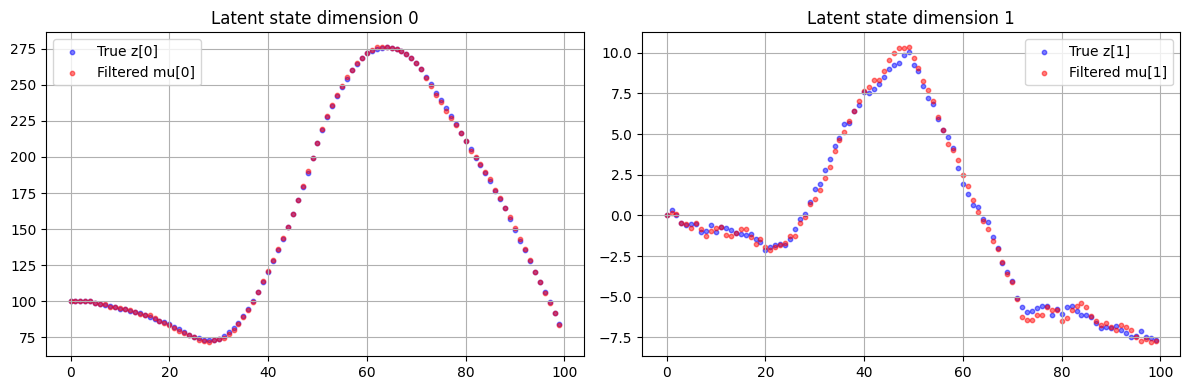

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axes[0].scatter(range(T), z[0, :], color="blue", s=10, alpha=0.5, label="True z[0]")
axes[0].scatter(range(T), mu[0, :], color="red", s=10, alpha=0.5, label="Filtered mu[0]")
axes[0].set_title("Latent state dimension 0")
axes[0].grid(True)
axes[0].legend()

axes[1].scatter(range(T), z[1, :], color="blue", s=10, alpha=0.5, label="True z[1]")
axes[1].scatter(range(T), mu[1, :], color="red", s=10, alpha=0.5, label="Filtered mu[1]")
axes[1].set_title("Latent state dimension 1")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [68]:
print(f"A: {A}, shape: {A.shape}")
print(f"C: {C}, shape: {C.shape}")

A: [[1. 1.]
 [0. 1.]], shape: (2, 2)
C: [0.2 1. ], shape: (2,)


The A matrix describes the time dependency of the latent state on the previous time step. Here, we add the velocity to the old postion values to obtain the new postion. The velocity does not get changed by A. The C matrix describes how the control variable influences postion and velocity. This could be commands from the pilot, and corresponding engine reactions, being translated to velocity and height.

$A$ models how the next latent state depends on the previous, letting $h_{t}, v_{t}$ respectively denote height and velocity we have
$$\begin{pmatrix} h_{t} \\ v_{t} \end{pmatrix} = A  \begin{pmatrix} h_{t-1} \\ v_{t-1} \end{pmatrix} + Cu_t + \epsilon_t= \begin{pmatrix} h_{t-1} + v_{t-1} \\ v_{t-1}\end{pmatrix} + Cu_t + \epsilon_t$$
Which is quite a sensible model for how the next height and velocity depends on the previous. 

$C$ models how the latent state depends on the control variable
$$\begin{pmatrix} h_{t} \\ v_{t} \end{pmatrix} = A z_{t-1} + C u_t + \epsilon_t= A z_{t-1} + \begin{pmatrix} 0.2 u_t \\ u_t \end{pmatrix} + \eta_t $$
It shows that the height is less susceptible to the control variable than the velocity. Their is a one to one correspondance between the control variable and the velocity. 



### 4)

In [69]:
def Kalman_filter_smoother(A,B,C,Gamma,L0,mu0,u,x,z,z0,T):
    # Define forwards quantities
    mu = np.empty((2,T))
    K = np.zeros((T,n,m))
    L = np.zeros((T,n,n))
    V = np.zeros((T,n,n))
    
    # Initialize system
    K[0] = L0 @ B.T @ inv(B @ L0 @ B.T + Gamma)
    V[0] = (np.identity(2) - K[0] @ B) @ L0
    L[0] = A @ V[0] @ A.T + Sigma
    mu[:, 0] = A @ mu0 + C * u[0] + K[0] @ (x[:, 0]- B @ (A @ mu0 + C * u[0]))
    
    # Loop forwards
    for t in range(1,T):
        L[t] = A @ V[t-1] @ A.T + Sigma     
        K[t] = L[t-1] @ B.T @ inv(B @ L[t-1] @ B.T + Gamma)
        V[t] = (np.identity(2) - K[t] @ B) @ L[t-1]
        mu[:,t] = A @ mu[:,t-1] + C * u[t] + K[t] @ (x[:, t]- B @ (A @ mu[:,t-1]+ C * u[t]))
    
    
    # Define backwards quantities
    mu_tilde = np.empty((2,T))
    mu_tilde[:, 99] = mu[:,99]
    
    V_tilde = np.zeros((T,n,n))
    V_tilde[T-1] = V[T-1]
    
    # Loop backwards
    for t in range(T-2,-1,-1):
       V_tilde[t] = V[t] + V[t] @ A.T @ inv(V[t]) @ (V_tilde[t+1] - L[t])@inv(L[t]).T @ A @ V[t].T
       mu_tilde[:, t] = mu[:, t] + V[t] @ A.T @inv(L[t]) @ (mu_tilde[:, t+1] - (A @ mu[:, t] + C * u[t]))
      
    
    return mu_tilde

In [70]:
mu_tilde = Kalman_filter_smoother(A=A,B=B,C=C,Gamma=Gamma,L0=L0,mu0=mu0,u=u,x=x,z=z,z0=z0,T=T)

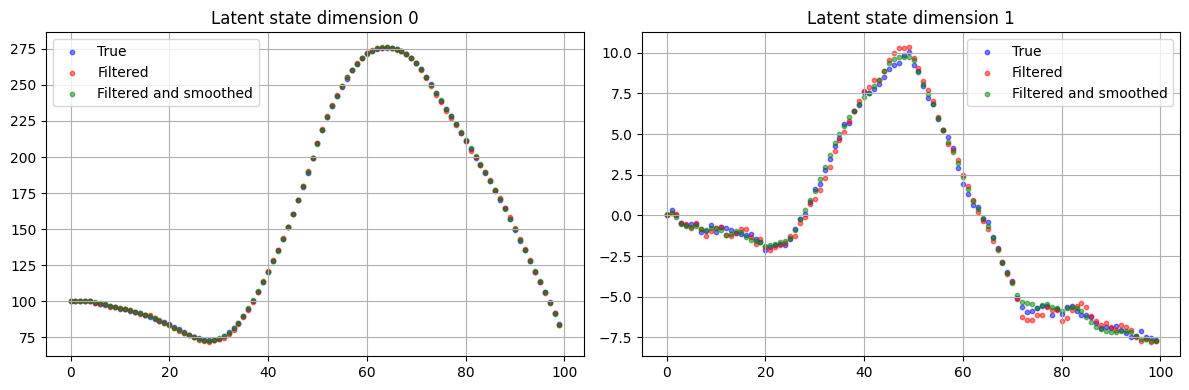

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axes[0].scatter(range(T), z[0, :], color="blue", s=10, alpha=0.5, label="True")
axes[0].scatter(range(T), mu[0, :], color="red", s=10, alpha=0.5, label="Filtered")
axes[0].scatter(range(T), mu_tilde[0, :], color="green", s=10, alpha=0.5, label="Filtered and smoothed")
axes[0].set_title("Latent state dimension 0")
axes[0].grid(True)
axes[0].legend()

axes[1].scatter(range(T), z[1, :], color="blue", s=10, alpha=0.5, label="True")
axes[1].scatter(range(T), mu[1, :], color="red", s=10, alpha=0.5, label="Filtered")
axes[1].scatter(range(T), mu_tilde[1, :], color="green", s=10, alpha=0.5, label="Filtered and smoothed")
axes[1].set_title("Latent state dimension 1")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [72]:
MSE_filter_pos = np.mean((z[0,:] - mu[0,:]) * (z[0,:] - mu[0,:]))
MSE_filter_smoother_pos = np.mean((z[0,:] - mu_tilde[0,:]) * (z[0,:] - mu_tilde[0,:]))

MSE_filter_vel = np.mean((z[1,:] - mu[1,:]) * (z[1,:] - mu[1,:]))
MSE_filter_smoother_vel = np.mean((z[1,:] - mu_tilde[1,:]) * (z[1,:] - mu_tilde[1,:]))


print(f"Filter: position error:{MSE_filter_pos} velocity error: {MSE_filter_vel}")
print(f"Filter-Smoother: position error:{MSE_filter_smoother_pos} velocity error: {MSE_filter_smoother_vel}")

Filter: position error:0.45658096783797025 velocity error: 0.11708262750192114
Filter-Smoother: position error:0.16354739508444457 velocity error: 0.05075655915901802


The smoother improves the MSE. Which makes sense, since we gain more information going backwards. When looking at the trajectores, we notice that the smoothed filter oscillates less.

In [62]:
# Total error
MSE_filter = np.mean((z - mu).flatten() * (z - mu).flatten())
MSE_filter_smoother = np.mean((z - mu_tilde).flatten() * (z - mu_tilde).flatten())
print(MSE_filter)
print(MSE_filter_smoother)

0.2868317976699457
0.10715197712173129
